## Prerequisites

In [6]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [7]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

## Metadata

In [25]:
# dataset_meta = ['allen_'+x for x in ['B05','B08','C01','F08','H12','A08','B01']]

dataset_meta = ['allen_'+x for x in ['B05','B08','C01','F08','H12','B01','A01']]
dataset_names = [x for x in dataset_meta ]  
raw_data_locations = [x for x in dataset_meta]
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [26]:
dataset_names

['allen_B05',
 'allen_B08',
 'allen_C01',
 'allen_F08',
 'allen_H12',
 'allen_B01',
 'allen_A01']

In [27]:
len(np.unique(dataset_names))

7

## Filtering

In [28]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy


In [29]:
def get_allen_meta(directory):
    allen_membership = pd.read_csv(directory+'/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
    allen_annot = pd.read_csv(directory+'/cluster.annotation.csv')
    allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
    allen_membership['sample'] = allen_membership['barcode'].str[-3:]
    allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
    allen_annot.set_index('cluster_id',inplace=True)
    allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
    meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
    return meta

In [30]:
meta_directory_v3 = '~/count_data/allen_metadata/sc'
meta_directory_v2 = '~/count_data/allen_metadata/sc_v2'
meta_v3 = get_allen_meta(meta_directory_v3)
meta_v2 = get_allen_meta(meta_directory_v2)

### Knee plot filtering and basic QC

In [39]:
replicates = ('B05','H12','A01')

Dataset B05. 
	5999 barcodes in loom, 5253 pass filter. 5442 in annotations; of these, 5440 in loom and 4886 in filtered loom.
Dataset B08. 
	10975 barcodes in loom, 9216 pass filter. 8424 in annotations; of these, 8424 in loom and 7808 in filtered loom.
Dataset C01. 
	12363 barcodes in loom, 11116 pass filter. 10173 in annotations; of these, 10138 in loom and 9066 in filtered loom.
Dataset F08. 
	28362 barcodes in loom, 10039 pass filter. 9112 in annotations; of these, 9112 in loom and 8510 in filtered loom.
Dataset H12. 
	9637 barcodes in loom, 8168 pass filter. 6866 in annotations; of these, 6865 in loom and 6161 in filtered loom.
Dataset B01. 
	11504 barcodes in loom, 9673 pass filter. 9772 in annotations; of these, 9772 in loom and 8764 in filtered loom.
Dataset A01. 
	8145 barcodes in loom, 6443 pass filter. 6355 in annotations; of these, 6355 in loom and 5797 in filtered loom.


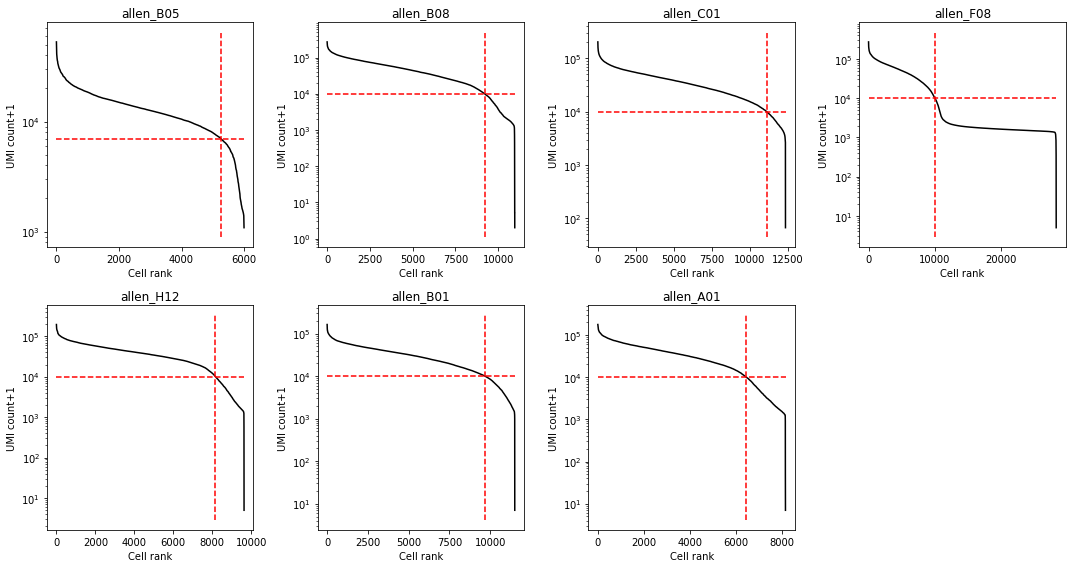

In [40]:
cf = []
thr_lb = [7e3] + [1e4]*6
# thr_lb = [1e3,3e3,3e3]
S_arr = []
U_arr = []
fig1,ax1 = plt.subplots(2,4,figsize=(15,8))

for k in range(len(dataset_meta)):
# for k in range(1):
    axloc = np.unravel_index(k,(2,4))
    filename = loom_filepaths[k ]
    dataset_name = raw_data_locations[k][-3:]
    
    if k > 0:
        meta = meta_v3
    else:
        meta = meta_v2
#     clusters = cluster_annotations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[axloc],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = (meta['sample']==dataset_name).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        annot_bcs = meta[(meta['sample']==dataset_name)]['cell_barcode']
#         cf
        if dataset_name in replicates:
            S_arr.append(S)
            U_arr.append(U)
        cf.append(np.isin(bcs,annot_bcs) & cf_)
#             print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')

    ax1[axloc].set_title(raw_data_locations[k])
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_allen.png'
plt.delaxes(ax1[1,3])
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)


### v2/v3 comparison

B05 is a male mouse squeakenced by v2. F08 and G08, two libraries generated from a single male mouse, were processed with v3.

Here, we compare the $\text{CV}^2$ values. They are much higher for the v2 datase, presumably due to technical noise.

/tmp/ipykernel_3630359/440059537.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_3630359/440059537.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


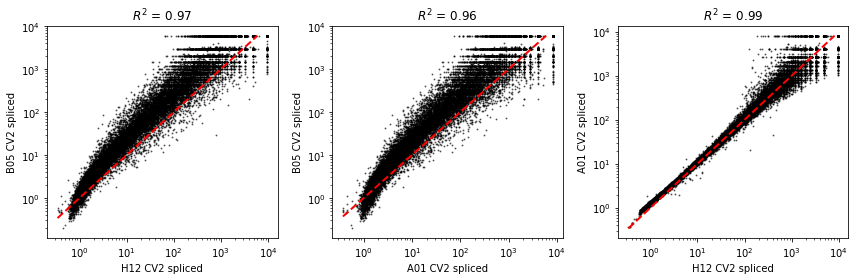

In [41]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = S_arr[k1]
    y = S_arr[k2]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(replicates[k1]+' CV2 spliced')
    ax1[q].set_ylabel(replicates[k2]+' CV2 spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

/tmp/ipykernel_3630359/657333974.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_3630359/657333974.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


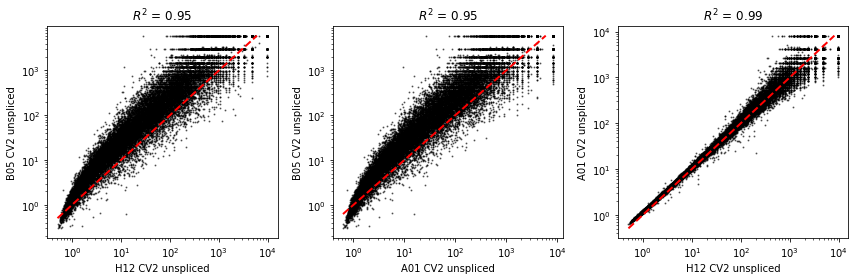

In [42]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = U_arr[k1]
    y = U_arr[k2]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(replicates[k1]+' CV2 unspliced')
    ax1[q].set_ylabel(replicates[k2]+' CV2 unspliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Meanwhile, the mean levels are lower in the v2 dataset.

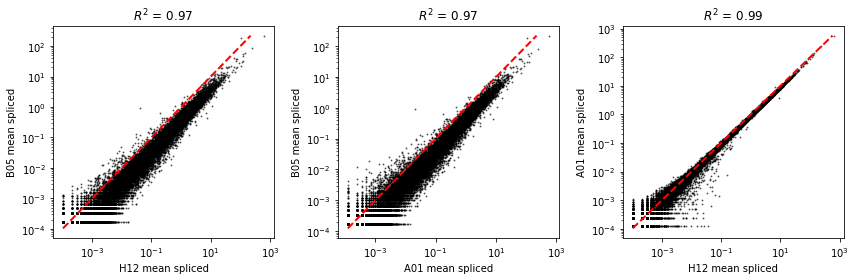

In [43]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = S_arr[k1]
    y = S_arr[k2]
    x = x.mean(1)
    y = y.mean(1)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(replicates[k1]+' mean spliced')
    ax1[q].set_ylabel(replicates[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

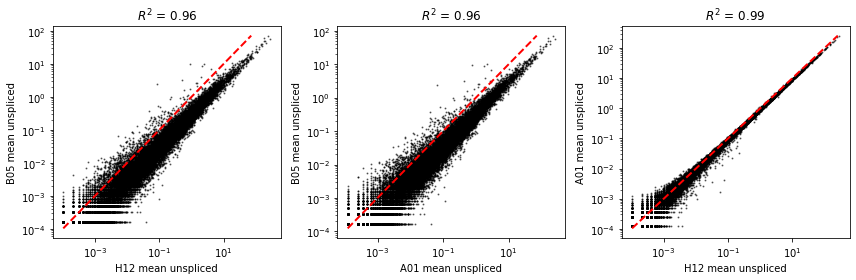

In [44]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = U_arr[k1]
    y = U_arr[k2]
    x = x.mean(1)
    y = y.mean(1)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(replicates[k1]+' mean unspliced')
    ax1[q].set_ylabel(replicates[k2]+' mean unspliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [45]:
[x.sum() for x in cf]


[4886, 7808, 9066, 8510, 6161, 8764, 5797]

## Preprocessing

In [46]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221118_025_allen_1 created.
INFO:root:Dataset: allen_B05
INFO:root:4886 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:3523 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B05 created.
INFO:root:Dataset: allen_B08
INFO:root:7808 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:8702 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B08 created.
INFO:root:Dataset: allen_C01
INFO:root:9066 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7683 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_C01 created.
INFO:root:Dataset: allen_F08
INFO:root:8510 cells detected.
INFO:root:32285 featu

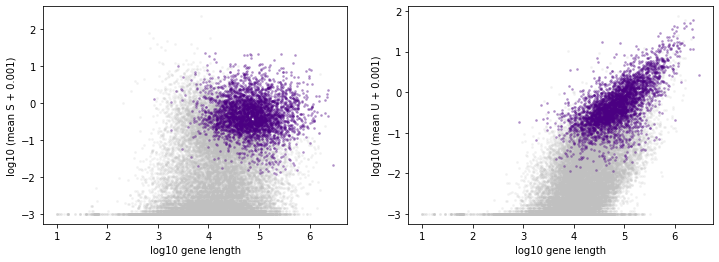

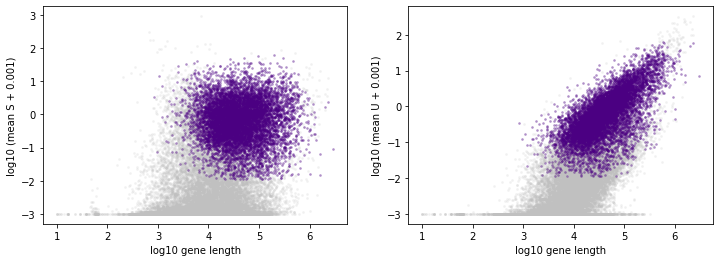

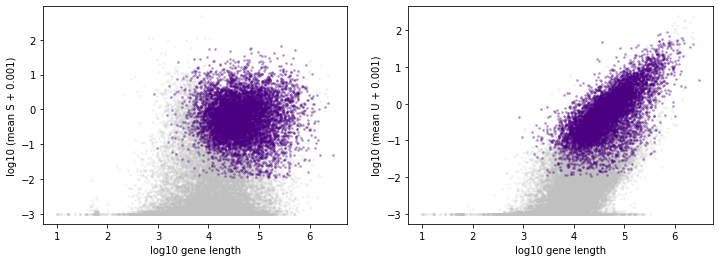

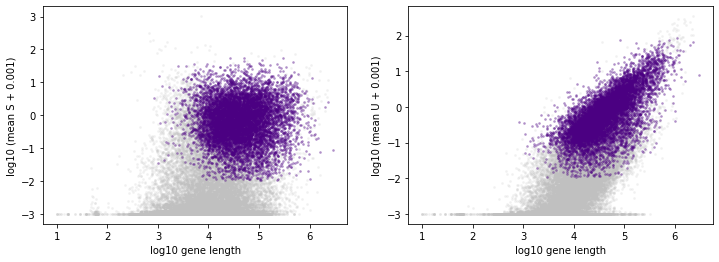

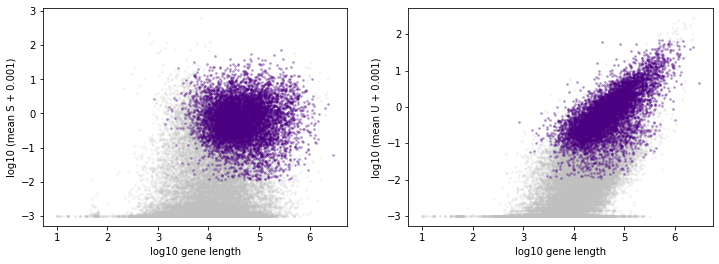

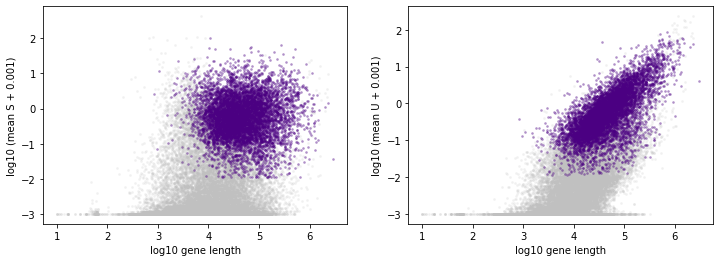

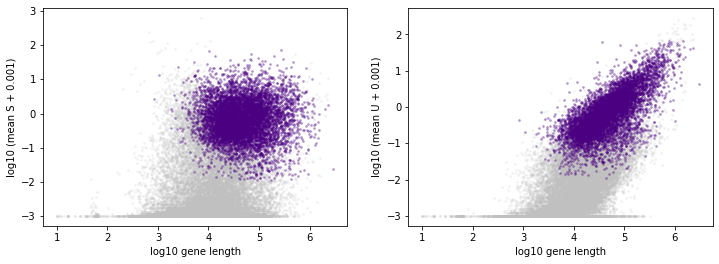

In [47]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen',batch_id=1,\
                                             n_genes=2500,exp_filter_threshold=None,cf=cf)

## Inference

In [48]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [49]:
dataset_names

['allen_B05',
 'allen_B08',
 'allen_C01',
 'allen_F08',
 'allen_H12',
 'allen_B01',
 'allen_A01']

INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B05
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B05/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_allen_1/allen_B05/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [35:17<00:00,  5.04s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 2120.6 seconds.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B08/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_allen_1/allen_B08/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [4:34:17<00:00, 39.18s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 16463.8 seconds.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_C01/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_allen_1/allen_C01/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_C01
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_C01/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_allen_1/allen_C01/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:36:48<00:00, 13.83s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_C01/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 5813.5 seconds.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_F08/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_allen_1/allen_F08/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_F08
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_F08/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_allen_1/allen_F08/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [4:44:52<00:00, 40.70s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_F08/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 17098.7 seconds.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_H12/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_allen_1/allen_H12/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_H12
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_H12/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_allen_1/allen_H12/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:45:30<00:00, 15.07s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_H12/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 6334.7 seconds.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B01/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_allen_1/allen_B01/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B01
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B01/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_allen_1/allen_B01/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:28:14<00:00, 12.61s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B01/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 5298.9 seconds.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_A01/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_allen_1/allen_A01/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_A01
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_A01/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_allen_1/allen_A01/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:29:51<00:00, 12.84s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_A01/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 5395.8 seconds.


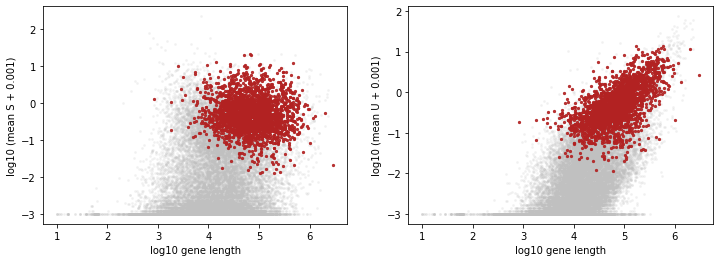

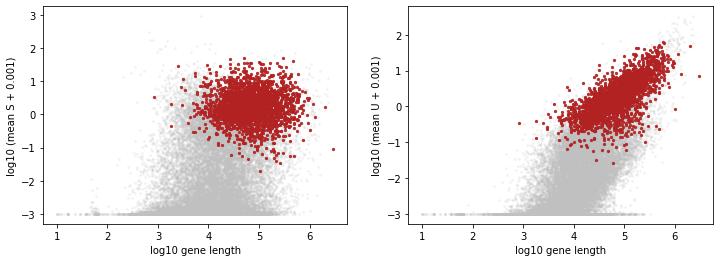

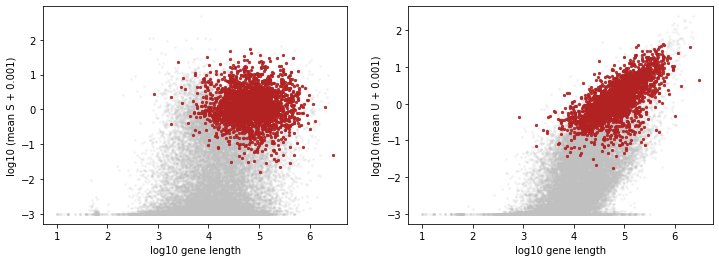

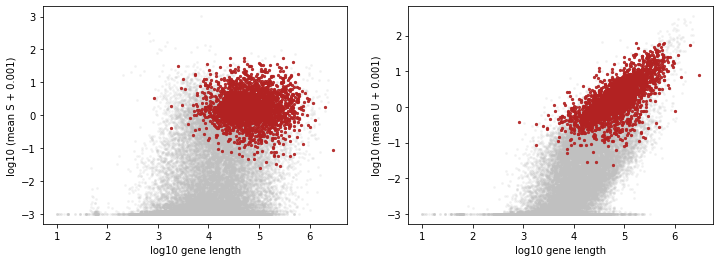

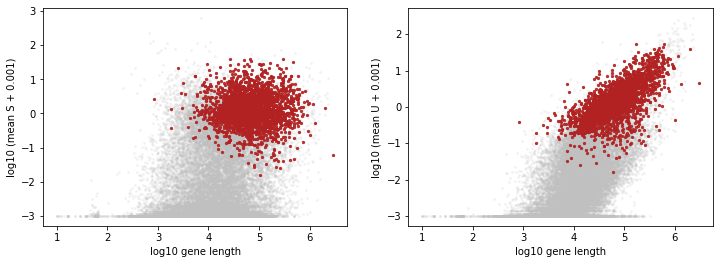

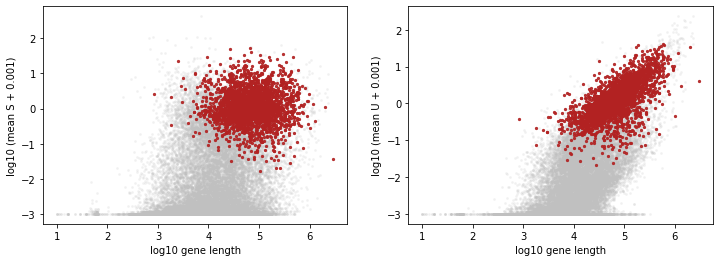

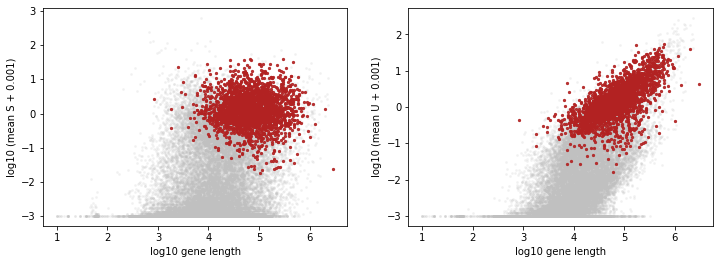

In [50]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-8, -2.5]
samp_ub = [-5, 0]
gridsize = [20,21]



result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
#                 gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':3})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data)
    result_strings.append(full_result_string)


## Post-processing

In [51]:
dataset_names

['allen_B05',
 'allen_B08',
 'allen_C01',
 'allen_F08',
 'allen_H12',
 'allen_B01',
 'allen_A01']

In [52]:
dir_string

'./fits/gg_221118_025_allen_1'

In [54]:
result_strings

['./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221118_025_allen_1/allen_C01/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221118_025_allen_1/allen_F08/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221118_025_allen_1/allen_H12/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221118_025_allen_1/allen_B01/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221118_025_allen_1/allen_A01/Bursty_Poisson_20x21/grid_scan_results.res']

INFO:root:Grid scan results loaded from ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_allen_1/allen_B05/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 27 genes out of 2500. Runtime: 6.0 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.74, -0.88.
INFO:root:Chi-square computation complete. Rejected 27 genes out of 2500. Runtime: 6.0 seconds.
INFO:ro

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221118_025_allen_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_allen_1/allen_B08/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 280 genes out of 2500. Runtime: 23.4 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B0

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_C01/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.


/home/ggorin/projects/monod/src/monod/inference.py:1003: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(nrows=1, ncols=num_params, figsize=figsize)


INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_C01/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221118_025_allen_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221118_025_allen_1/allen_F08/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_allen_1/allen_F08/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_F08/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_F08/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 263 genes out of 2500. Runtime: 24.2 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_F08/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_F

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_F08/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_F08/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221118_025_allen_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221118_025_allen_1/allen_H12/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_allen_1/allen_H12/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_H12/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_H12/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 182 genes out of 2500. Runtime: 16.2 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/a

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B01/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_B01/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221118_025_allen_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221118_025_allen_1/allen_A01/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_allen_1/allen_A01/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_A01/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/allen_A01/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 209 genes out of 2500. Runtime: 15.8 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_allen_1/a

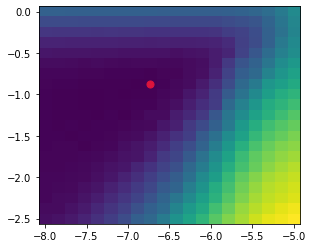

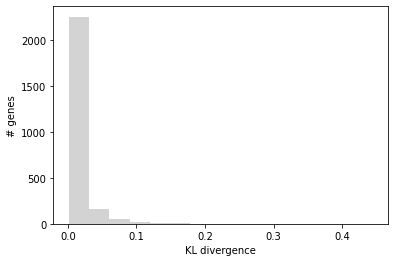

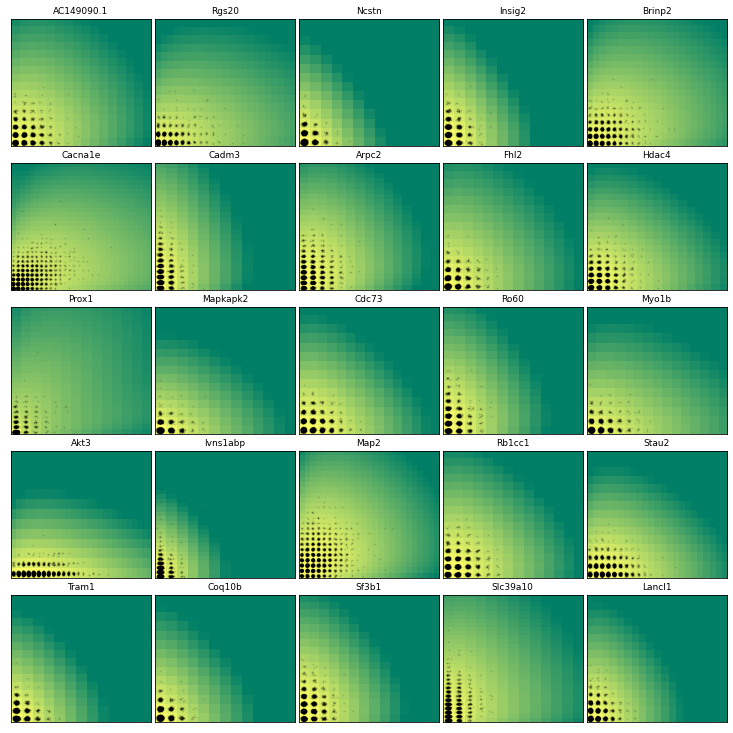

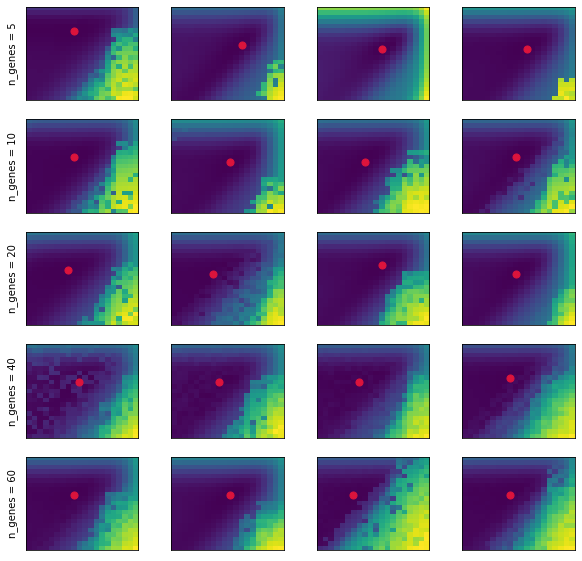

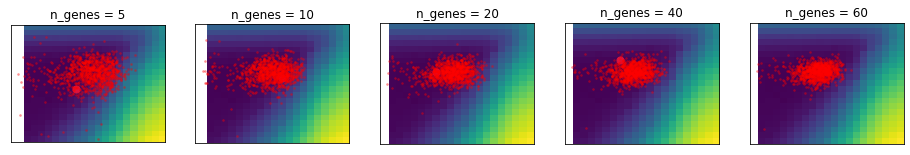

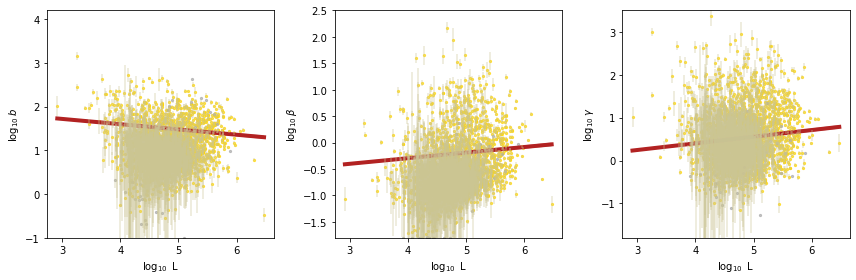

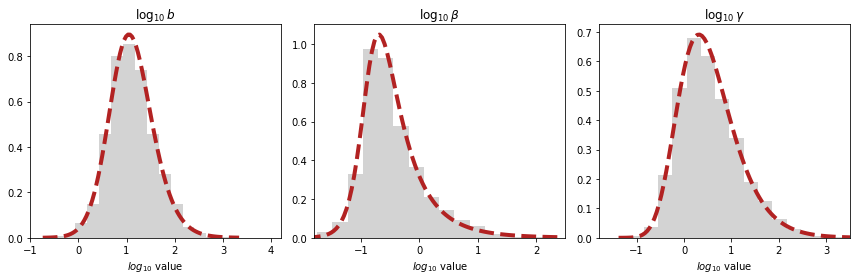

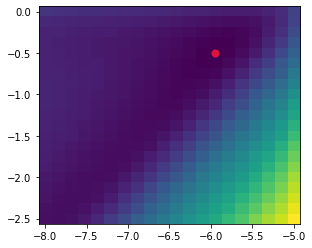

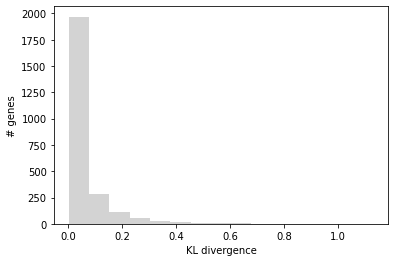

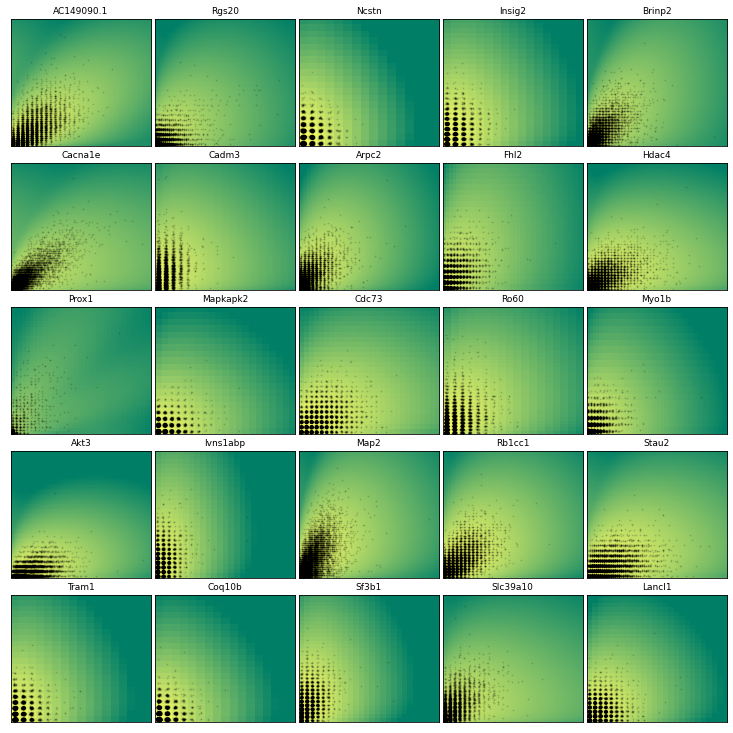

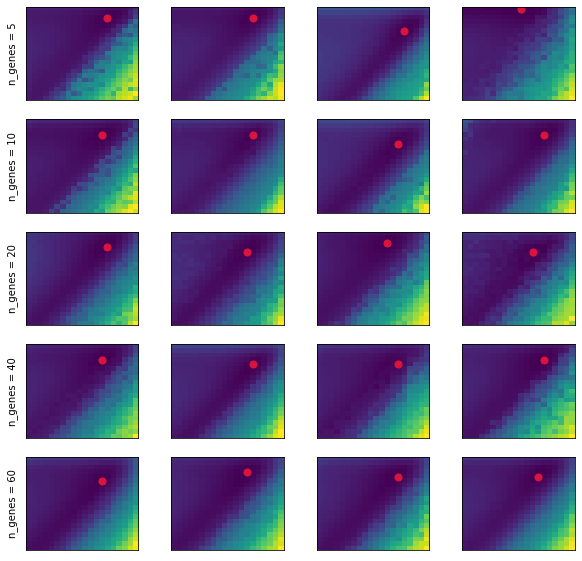

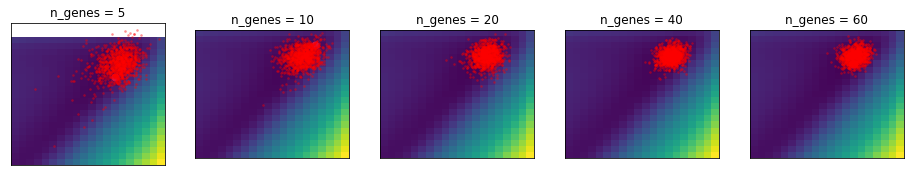

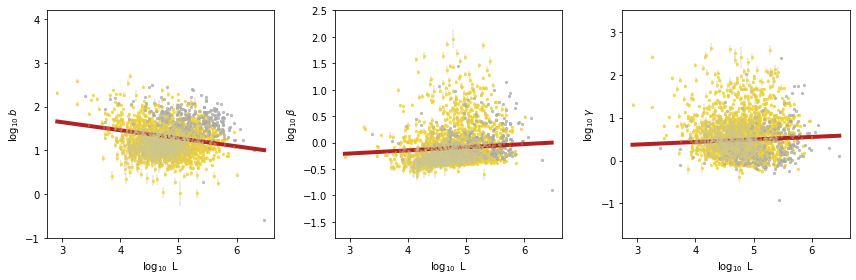

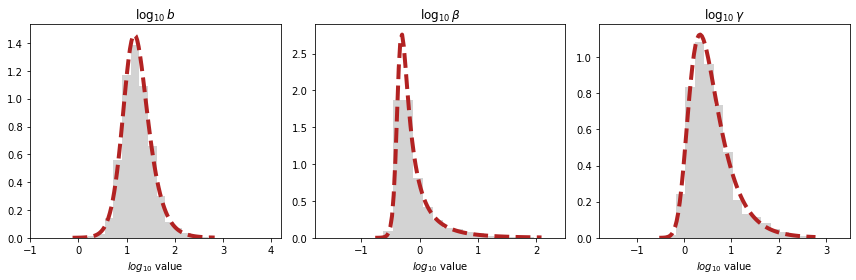

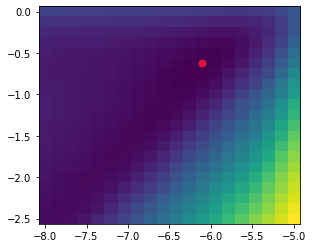

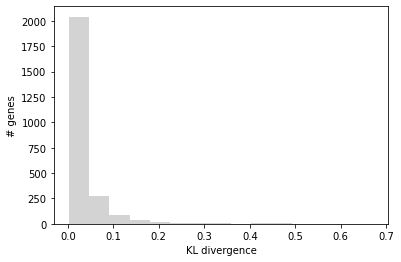

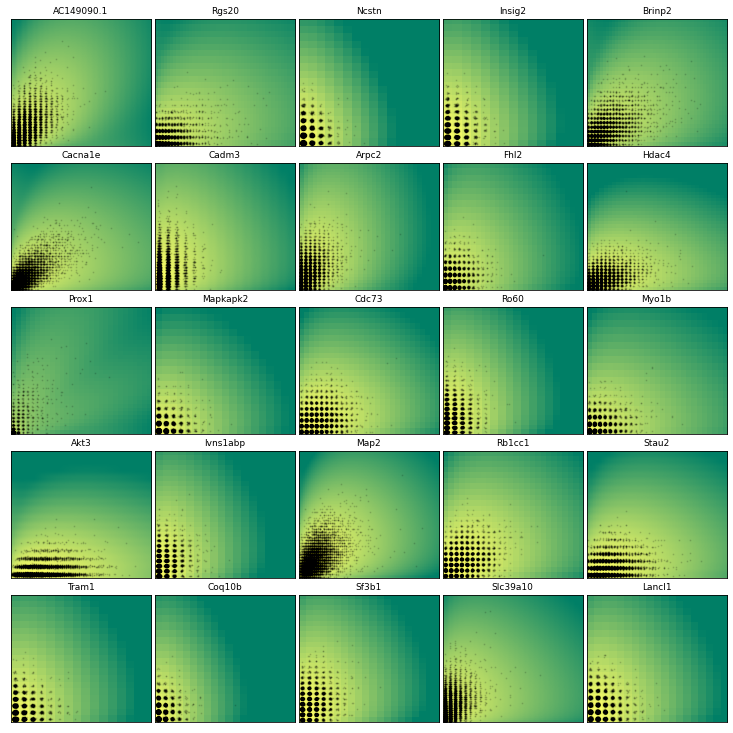

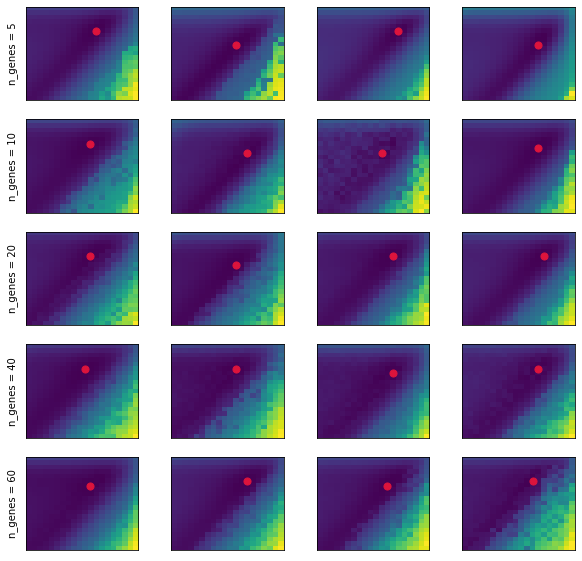

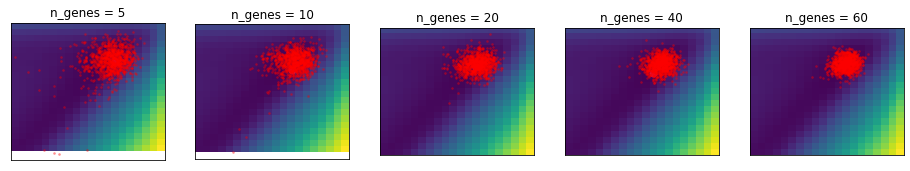

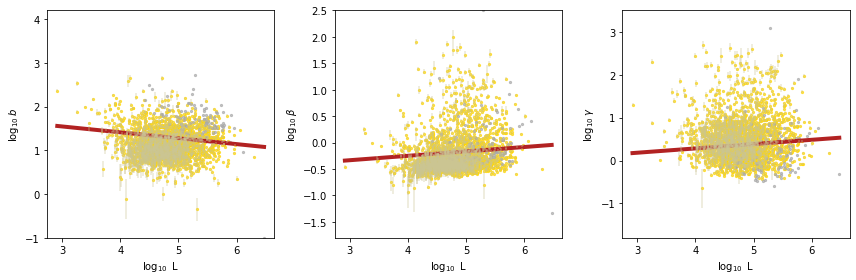

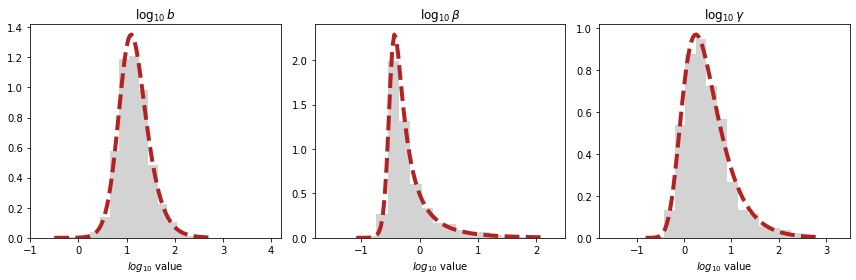

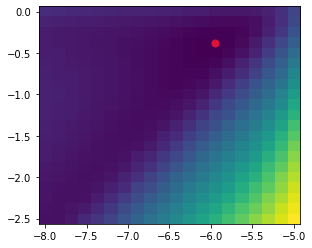

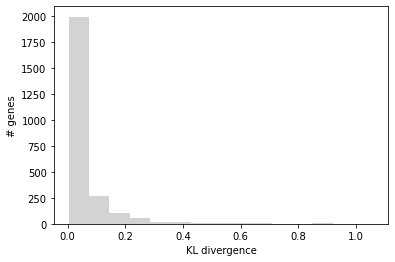

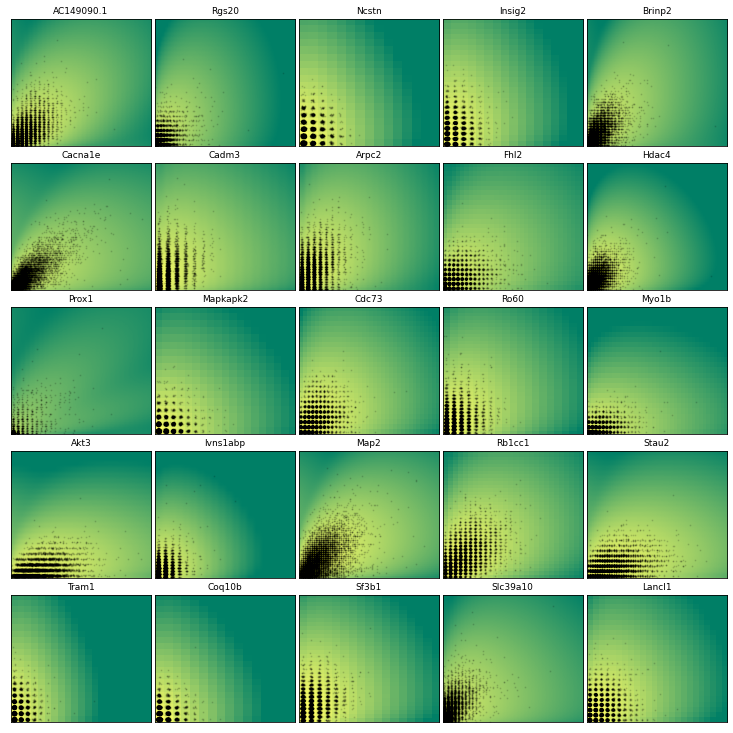

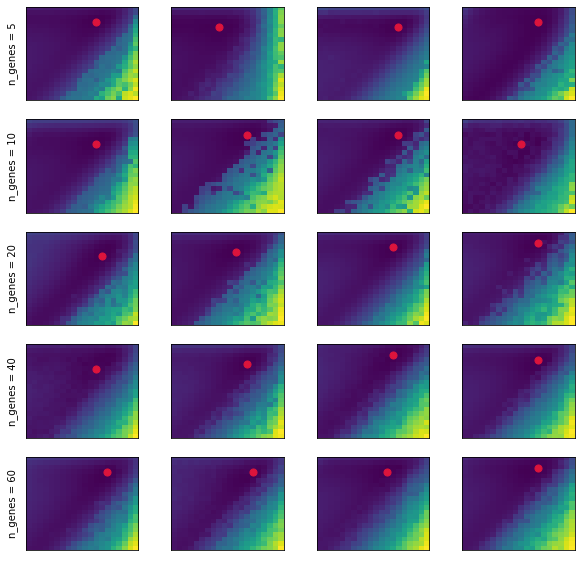

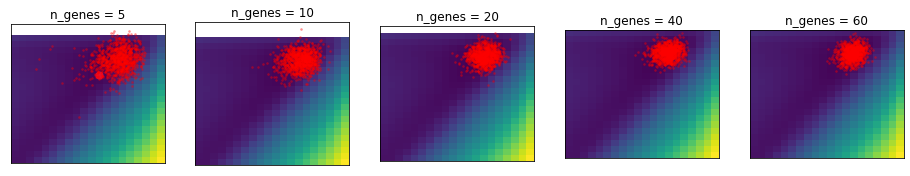

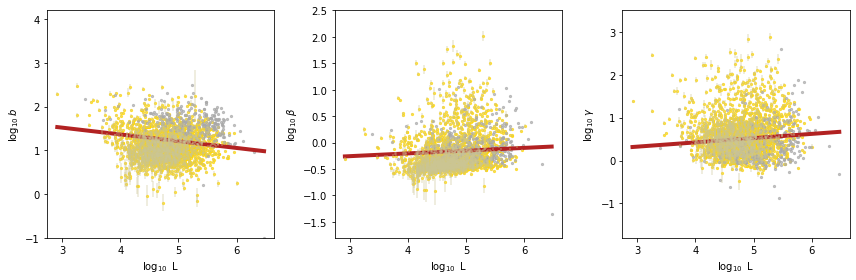

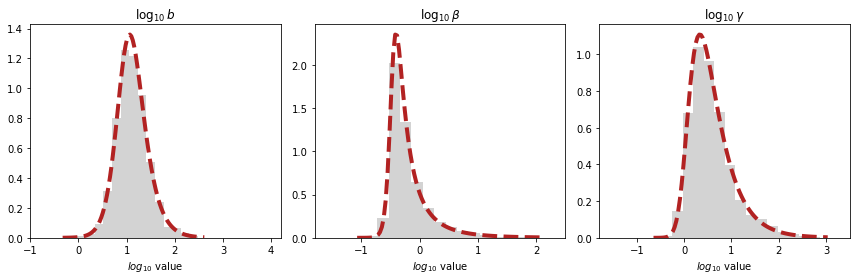

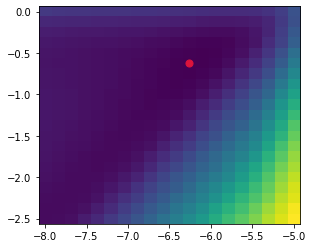

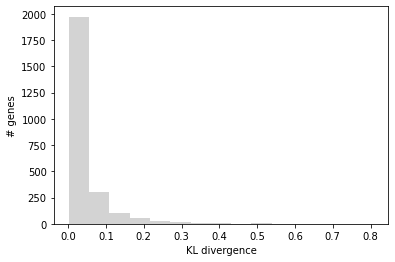

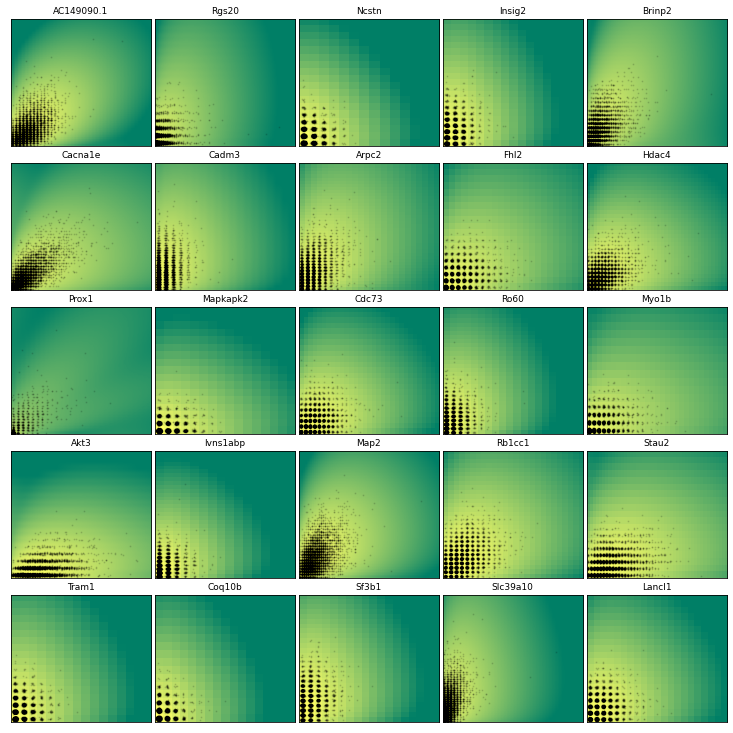

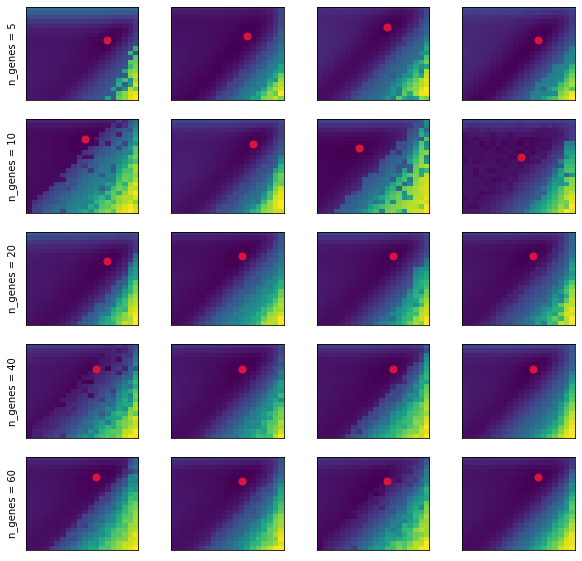

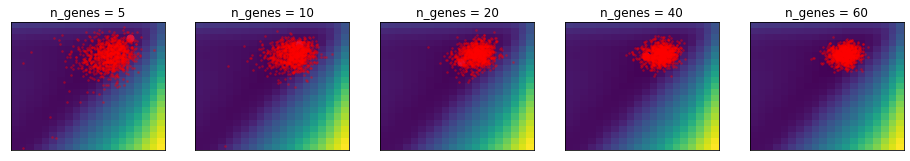

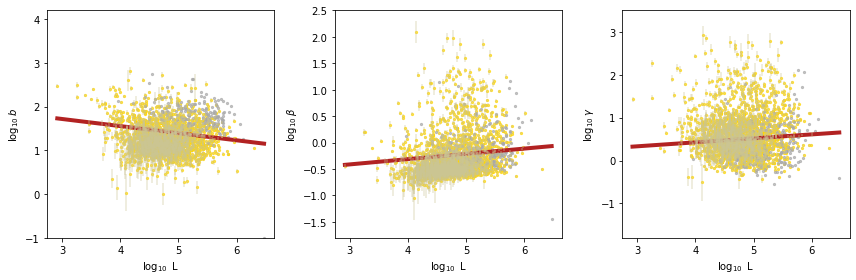

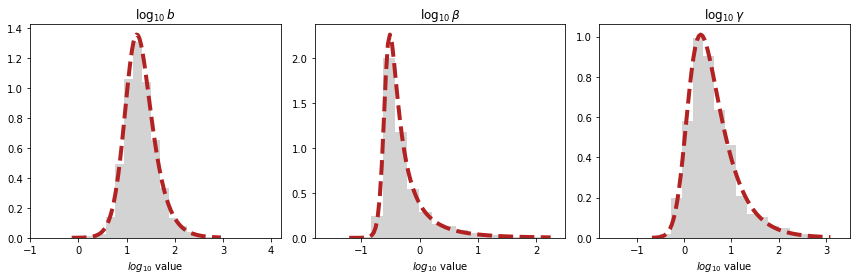

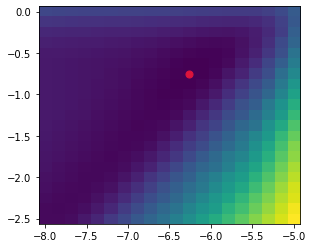

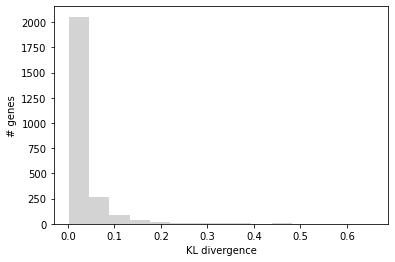

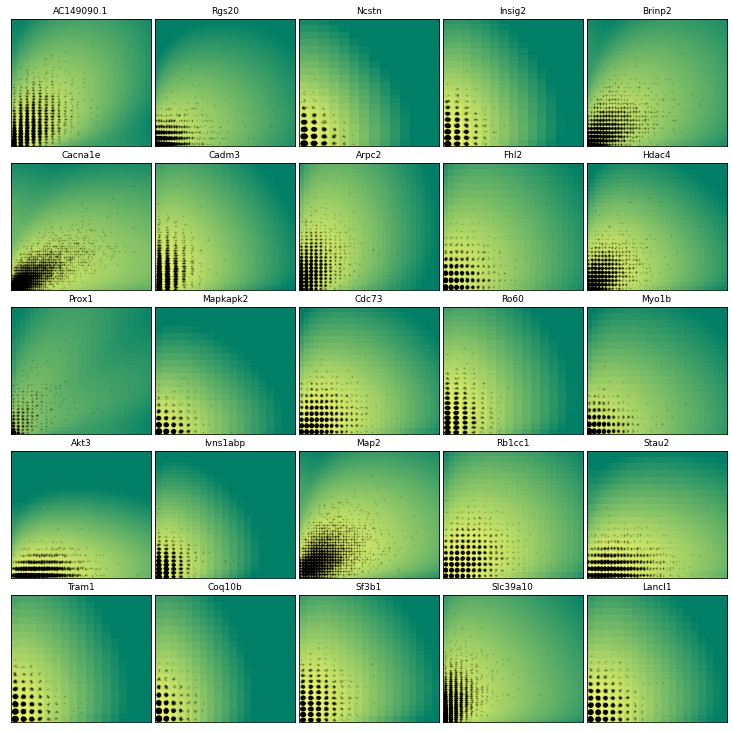

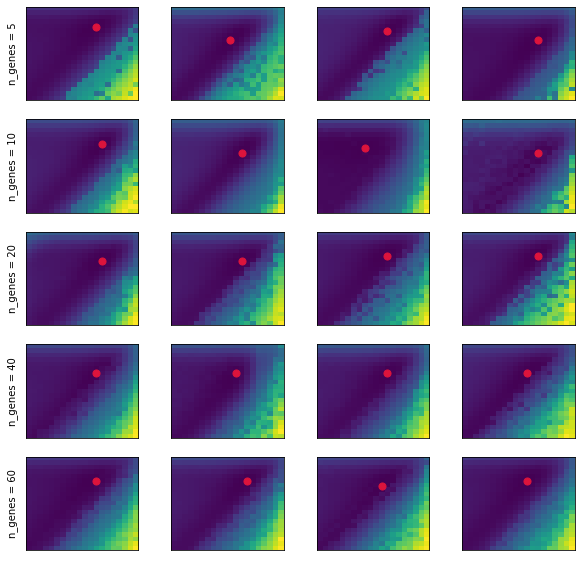

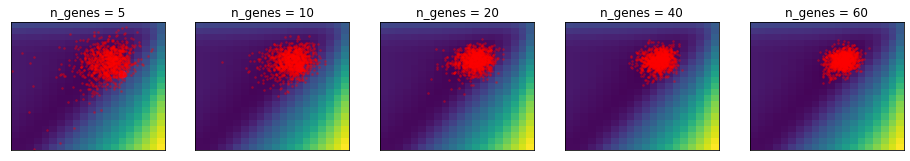

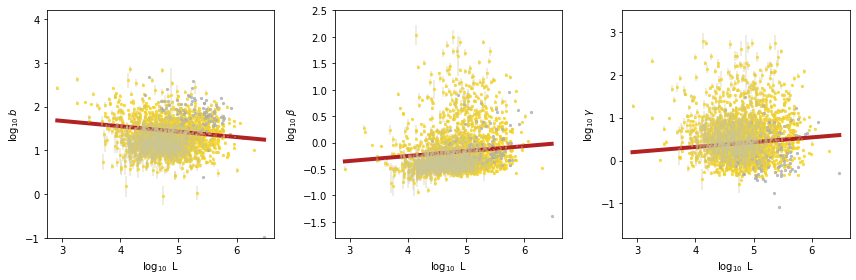

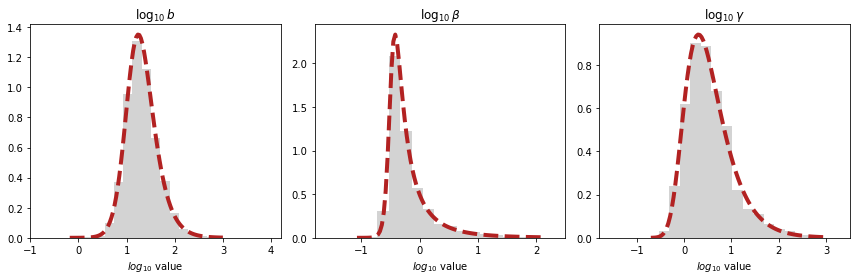

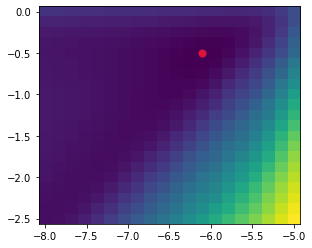

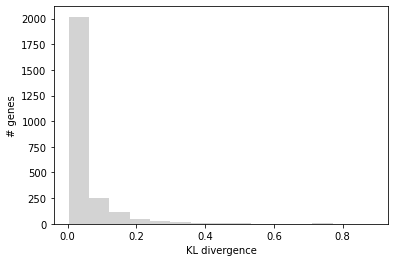

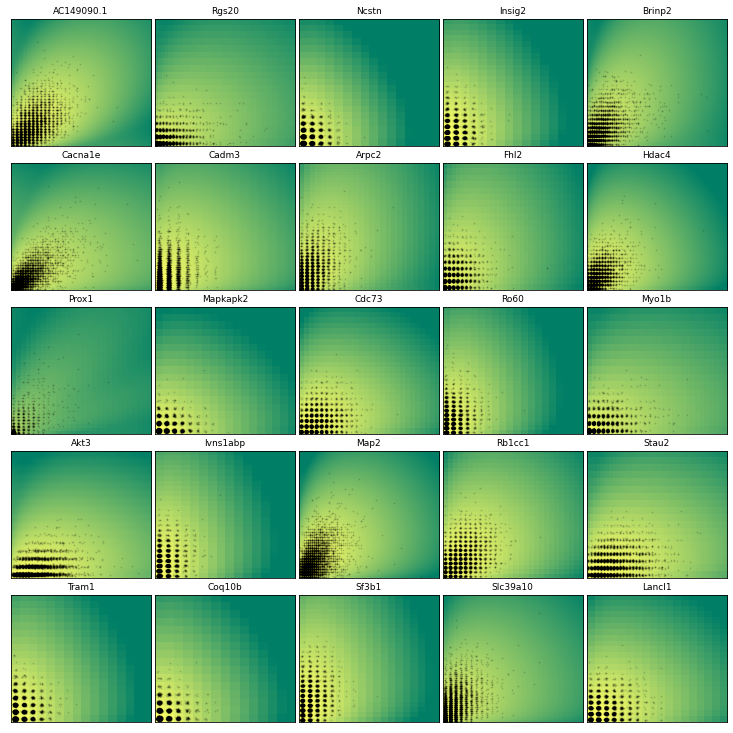

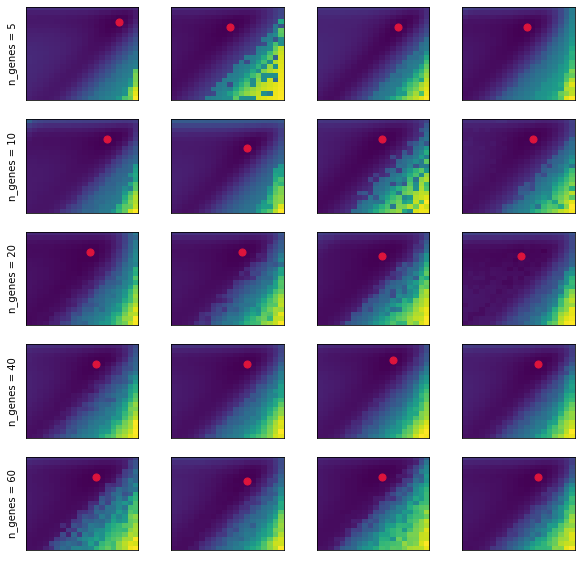

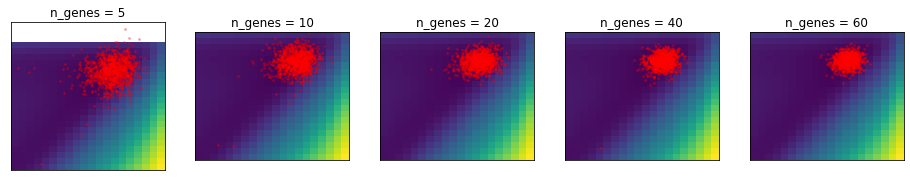

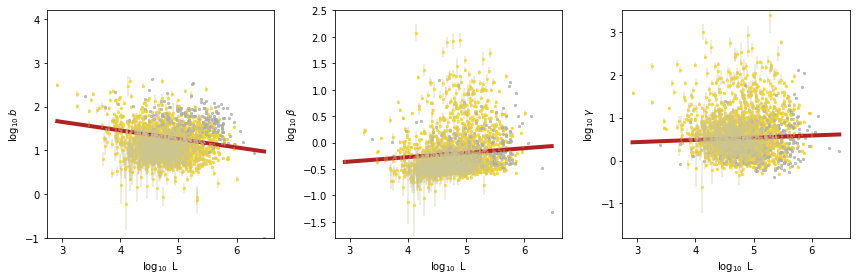

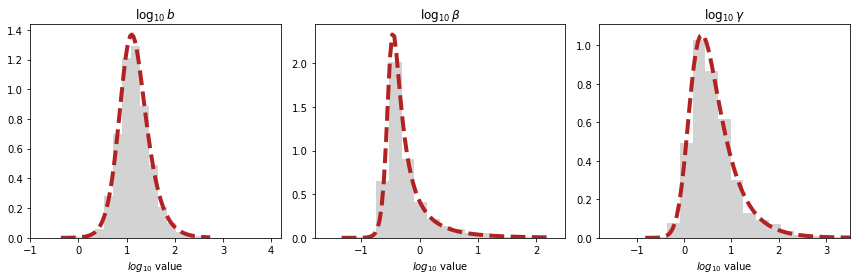

In [55]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


In [7]:
dir_string = './fits/gg_221118_025_allen_1'
result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results.res' for x in dataset_names]

In [ ]:
sr_arr = [ monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]